In [3]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import cv2 as cv
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2022-06-23 21:21:12.067959: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-23 21:21:12.110604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dana/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-23 21:21:12.110618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
pd.__version__

'1.4.2'

In [6]:
np.__version__

'1.22.4'

In [7]:
sns.__version__

'0.11.2'

In [8]:
matplotlib.__version__

'3.5.2'

In [9]:
current_directory = !pwd
path = current_directory[0] + '/chest_xray'
print(path)

/home/dana/redes-neuronales/pneumonia-cnn-classifier/chest_xray


In [10]:
!pip install Pillow
from PIL import Image

In [25]:
import os

normal_train = len(next(os.walk(path + '/train/NORMAL'))[2])
pneumonia_train = len(next(os.walk(path + '/train/PNEUMONIA'))[2])
normal_test = len(next(os.walk(path + '/test/NORMAL'))[2])
pneumonia_test = len(next(os.walk(path + '/test/PNEUMONIA'))[2])
normal_val = len(next(os.walk(path + '/val/NORMAL'))[2])
pneumonia_val = len(next(os.walk(path + '/val/PNEUMONIA'))[2])
print(normal_train + pneumonia_train + normal_test + pneumonia_test +normal_val + pneumonia_val)

5856


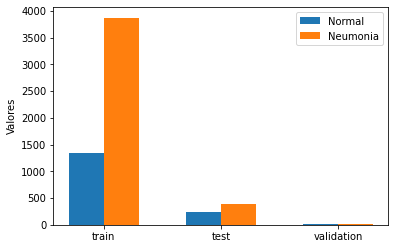

In [24]:
labels = ['train', 'test', 'validation']
normal = [normal_train, normal_test, normal_val ]
pneumonia = [pneumonia_train, pneumonia_test,pneumonia_val ]

x = np.arange(len(labels))
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia, width, label='Neumonia')

ax.set_ylabel('Valores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
###################################################################################################################

In [12]:
train_dir = current_directory[0] + "/chest_xray/train"
test_dir = current_directory[0] + "/chest_xray/test"
val_dir = current_directory[0] + "/chest_xray/val"

img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)

val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
########################################### V G G 1 9 ####################################################

In [24]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model

# lo que nosotros entendemos es que el parametro que paso es para specificity
# Como sensitivity es true positives y specificity son true negatives
# nos parecio mas importante tener un sentitivity alto, dado que "te dijimos que no tenias neumonia" y si tenias, es el peor caso
# por eso decidimos utilizar SensitivityAtSpecificity(0.5) con 0.5, dado que 
# un true negative en la mitad de los casos no es tan malo.
#es preferible acertarble en la mayoria de los casos true positives 

#PREGUNTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR PORQUE NO ENTIENDO NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH

model.compile(loss='mse', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [25]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [26]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 502s 5s/step - loss: 0.1883 - sensitivity_at_specificity_1: 0.4649 - val_loss: 0.3094 - val_sensitivity_at_specificity_1: 0.5000 - lr: 0.0100
Epoch 2/30
100/100 [==============================] - 504s 5s/step - loss: 0.1892 - sensitivity_at_specificity_1: 0.6150 - val_loss: 0.2952 - val_sensitivity_at_specificity_1: 0.8750 - lr: 0.0100
Epoch 3/30
100/100 [==============================] - 493s 5s/step - loss: 0.1843 - sensitivity_at_specificity_1: 0.7449 - val_loss: 0.3024 - val_sensitivity_at_specificity_1: 1.0000 - lr: 0.0100
Epoch 4/30
100/100 [==============================] - 511s 5s/step - loss: 0.1816 - sensitivity_at_specificity_1: 0.7715 - val_loss: 0.2968 - val_sensitivity_at_specificity_1: 1.0000 - lr: 0.0100
Epoch 5/30
100/100 [==============================] - 485s 5s/step - loss: 0.1787 - sensitivity_at_specificity_1: 0.8212 - val_loss: 0.2941 - val_sensitivity_at_specificity_1: 1.0000 - lr: 0.0100
Epoch 6/30
100/100 [

In [ ]:
# Evaluating the model on train and test
score = model.evaluate(train)
print(score)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

In [ ]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
###################################### X C E P T I O N ###############################################

In [ ]:
'''
INVESTIGAR QUE PORONGA HACE CADA PARAMETRO
tf.keras.applications.xception.Xception(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
'''

xception_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in xception_model.layers:
    layer.trainable=False
    
x = xception_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=xception_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
#PREGUNTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR PORQUE NO ENTIENDO NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH

#QUE DIFERENCIA TIENE LA REGRESION ACA? NO ENTIENDO

#model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])
model.compile(loss='mse', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [ ]:
###################################### I N C E P T I O N   V 3  ###############################################

In [ ]:
'''

'''

inceptionv3_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in inceptionv3_model.layers:
    layer.trainable=False
    
x = inceptionv3_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=inceptionv3_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
#PREGUNTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR PORQUE NO ENTIENDO NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH

#QUE DIFERENCIA TIENE LA REGRESION ACA? NO ENTIENDO

#model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])
model.compile(loss='mse', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [ ]:
###################################### R E S N E T   50  ###############################################

In [ ]:
'''

'''

resnet50_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in resnet50_model.layers:
    layer.trainable=False
    
x = resnet50_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=resnet50_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
#PREGUNTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR PORQUE NO ENTIENDO NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH

#QUE DIFERENCIA TIENE LA REGRESION ACA? NO ENTIENDO

#model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])
model.compile(loss='mse', optimizer='sgd',metrics=[tf.keras.metrics.SensitivityAtSpecificity(0.5)])